# Directly Calculating ∆F From Data
© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [30]:
import sys
sys.path.insert(0, '../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
constants = mut.thermo.load_constants()
mut.viz.plotting_style()
colors = mut.viz.color_selector('mut')
pboc = mut.viz.color_selector('pboc')

In [60]:
data = pd.read_csv('../../data/csv/compiled_data.csv')
data.dropna(inplace=True)
data = data[data['class'] != 'WT']

In [94]:
# Start only with the DNA binding mutants. 
# DNA = data[(data['class'] == 'DNA') & (data['operator'] == 'O2')].copy()

# Mark measurements beyond bounds. 
data['nonphysical'] = (data['fold_change'] <=0) + (data['fold_change'] >= 1)

# Calculate the empirical bohr. 
data['empirical_F'] = np.log((1 / data['fold_change']) - 1)

# Insert the wt bohr parameter. 
epr = [constants[op] for op in data['operator']]
wt_bohr = -mut.thermo.SimpleRepression(R=data['repressors'], ep_r=epr,
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], n_sites=constants['n_sites'],
                                     effector_conc=data['IPTGuM']).bohr_parameter()
data['wt_bohr'] = wt_bohr

# Compute the empirical Delta F
data['delta_F'] = data['wt_bohr'] - data['empirical_F']

# Group by IPTG and compute means and sem.
grouped = data.groupby(['class', 'IPTGuM', 'mutant', 'repressors', 'operator']).agg(('mean', 'sem')).reset_index()
grouped['valid'] = 0
grouped.loc[grouped['nonphysical']['mean'] == 0, 'valid'] = 1

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


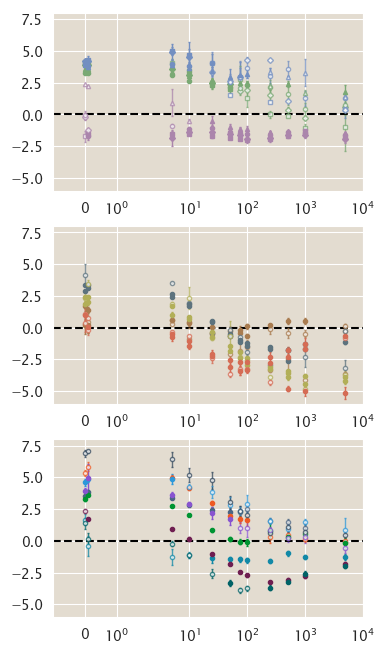

In [159]:
# Define the colors and glyphs. 
glyphs = {60:'s', 124:'D', 260:'o', 1220: '^'}
fig, ax = plt.subplots(3, 1, figsize=(4, 8), dpi=100)
axes = {'DNA': ax[0], 'IND':ax[1], 'DBL':ax[2]}
for g, d in grouped.groupby(['class', 'mutant', 'repressors', 'valid']):
    _ax = axes[g[0]]
    d = d.reset_index()
    if g[-1] == 1:
        alpha = 1
        fc=colors[g[1].upper()]      
    else:
        alpha = 0.75
        fc='w'             
   
    _ = _ax.errorbar(d['IPTGuM'], d['delta_F']['mean'], d['delta_F']['sem'], 
                       fmt=glyphs[g[2]], color=colors[g[1].upper()], lw=1, linestyle='',
                       capsize=1, alpha=alpha, markerfacecolor=fc, ms=3)


for a in ax:
    a.set_xscale('symlog')
    a.hlines(0, -1, 1E4, linestyle='dashed', color='k')
    a.set_xlim([-1, 1E4])
    a.set_ylim([-6, 8])


# Separating by mutant

In [133]:
# Load the DNA mutant sampling statistics
stats = pd.read_csv('../../data/csv/DNA_binding_energy_summary.csv')
stats.drop_duplicates(inplace=True)

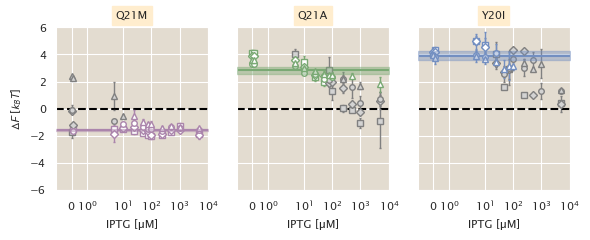

In [179]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2.5), dpi=100, sharey=True)
axes = {'Q21M':ax[0], 'Q21A':ax[1], 'Y20I':ax[2]}
for g, d in grouped[(grouped['class']=='DNA') & (grouped['operator']=='O2')].groupby(['mutant', 'repressors', 'valid']):
    if g[-1] == 0:
        fc='lightgray'
        color='gray'
        label='__nolegend__'
    else:
        fc='w'
        color=colors[g[0]]
        label=int(g[1])

    
    _ = axes[g[0]].errorbar(d['IPTGuM'], d['delta_F']['mean'], d['delta_F']['sem'], linestyle='',
                            markersize=4, color=color, fmt=glyphs[g[1]],
                            lw=1, capsize=1, markerfacecolor=fc, label=label)

for mu, _ax in axes.items():  
    # Plot the credible regions. 
    _stats = stats[(stats['parameter']=='ep_RA') &
                                   (stats['repressors']==260) &
                                   (stats['operator']=='O2') & 
                                   (stats['mutant']==mu)]
    mode = _stats['mode'].values[0]
    min_val = _stats['hpd_min'].values[0]
    max_val = _stats['hpd_max'].values[0]
    _ax.hlines(-(-13.9 - mode), -1, 1E4, color=colors[mu])
    _ax.fill_between(np.linspace(-1, 1E4, 300), -(-13.9-max_val), -(-13.9-min_val), color=colors[mu], alpha=0.4, zorder=1000)
    _ax.set_title(f'{mu}', backgroundcolor=pboc['pale_yellow'], fontsize=8) 
    
for a in ax:
    a.set_xscale('symlog')
    a.set_ylim([-6, 6])
    a.hlines(0, -1, 1E4, linestyle='--', label='__nolegend__')
    a.set_xlim([-1, 1E4])
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
    a.set_xlabel('IPTG [µM]', fontsize=8)
    _ = a.legend(fontsize=8, title='$R$', ncol=2)
ax[0].set_ylabel('$\Delta F$ [$k_BT$]', fontsize=8)

plt.tight_layout()